# Modello convolutivo di base
Di seguito verrà creato un **modello convolutivo di base** con un'architettura semplice. In seguito, sarà interessante confrontare i risultati di questo primo modello con i risultati ottenuti da modelli più complessi, o pre addestrati.

Come è solito, si procede con l'importazione delle librerie utilizzate e la creazione dei set di allenamento e validazione.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [3]:
for audios, labels in train_ds:
    print("Forma (shape) audio:", audios.shape)
    print("Forma (shape) classi:", labels.shape)
    break

Forma (shape) audio: (32, 16000, 1)
Forma (shape) classi: (32,)


Lo shape dell'audio è di (32, 16000, 1), indicando che ogni file è contenuto in un batch di 32 tensori unidimensionali di lunghezza 16000. Inoltre, lo shape delle classi è anch'esso 32. Questo perché la funzione `tf.keras.utils.audio_dataset_from_directory(directory)` ha il parametro `batch_size` impostato a 32 di default, non avendolo specificato la dimensione è rimasta tale.

## Funzioni per processamento dei dati

Il prossimo step è definire la funzione `squeeze(audio, labels)`, la quale prende come argomenti l'audio e le classi.

Questo funzione serve per rimuovere l'ultimo asse dello shape dai nostri audio. Attualmente, lo shape dei dati è (32, 16000, 1), ma si può eliminare l'ultima dimensione poiché non necessaria. Specificando il parametro **axis=-1** nella funzione `tf.squeeze` la forma dell'audio viene trasformata in (32, 16000).

Eseguiamo questa semplificazione sulla forma del dato poiché rende la fase di processamento dei dati più efficiente.

In [4]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [5]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


Una volta eseguito questa semplificazione, a partire dai tensori degli audio, creeremo gli spettrogrammi che sarannò presi come input dal modello convolutivo.

## Conversione e suddivisione dataset
Andremo ad utilizzare due funzioni: `get_spectrogram` e `get_spectrogram_dataset`. Queste due funzioni usate insieme creano un dataset di spettrogrammi. La prima funzione `get_spectrogram` converte il singolo audio in spettrogramma mentre la seconda funzione `get_spectrogram_dataset` richiama la prima funzione per ogni dato presente nel dataset.

In [6]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram[..., tf.newaxis]

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [7]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Definite le due funzioni possiamo procedere a ottenere il nostro training set, validation set, e test set di spettrogrammi. La suddivisione di dati ricordo essere rispettivamente 60%, 20%, 20%.

In [8]:
train_ds = get_spectrogram_dataset(train_ds)
validation_ds = get_spectrogram_dataset(validation_ds)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

In [9]:
print("Numero di audio training set:", len(train_ds) * 32)
print("Numero di audio validation set:", len(val_ds) * 32)
print("Numero di audio test set:", len(test_ds) * 32)

Numero di audio training set: 7776
Numero di audio validation set: 2592
Numero di audio test set: 2592


Shape (forma) spettrogrammi: (32, 124, 129, 1)


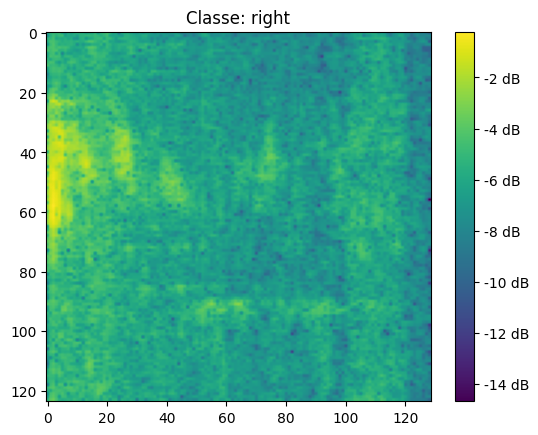

In [10]:
for audio, label in train_ds:
    print("Shape (forma) spettrogrammi:", audio.shape)

    spectrogram = np.squeeze(audio[0])
    spectrogram = np.log(spectrogram.T)

    plt.imshow(spectrogram.T)
    plt.colorbar(format='%+2.0f dB')

    plt.title(f"Classe: {label_names[label[0].numpy()]}")
    break

La grandezza degli spettrogrammi, quindi delle immagini ottenute, è di **124x129**.

## Creazione modello di base

Come primo modello implementiamo una rete neurale convolutiva. Questo modello ha un'architettura semplice e servirà da benchmark per i modelli futuri.

La rete prende in ingresso tensori di forma altezza x larghezza x canali, rispettivamente di 124, 129, 1. Per farlo lavorare meglio, rendiamo le immagini di mensione quadrate e normalizziamo i dati con la funzione `tf.keras.layers.Normalization()`.
L'architettura si basa su blocchi di due strati convolutivi con attivazione `ReLu` per aggiungere non linearità, seguiti da uno strato maxpooling.

In [11]:
def get_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Resizing(120, 120)(inputs)
    x = tf.keras.layers.Normalization()(x)

    # Livelli per l'apprendimento della rappresentazione delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
basic_model = get_basic_model()
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

basic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 120, 120, 1)       0         
                                                                 
 normalization (Normalizati  (None, 120, 120, 1)       3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 58, 58, 32)        0         
 D)                                                          

La dimensione dell'output dell'ultimo livello convolutivo è di (None, 25, 25, 256), cioè **256** feature maps di dimensione **25 x 25**. Eseguiamo il livello `Flatten` per vettorizzare le feature map, cosi da poterle passare in ingresso al livello `Dense`. Utilizziamo la funzione di attivazione softmax perché il task è di classificazione multiclasse, con 30 classi di output. Il modello ha un totale di circa **5 milioni di parametri**, bilanciando complessità e capacità di apprendimento.

In [13]:
basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/basic_model.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 10s 25ms/step - loss: 2.4062 - accuracy: 0.3492 - val_loss: 1.5536 - val_accuracy: 0.5787
Epoch 2/30
243/243 [==============================] - 5s 21ms/step - loss: 1.0664 - accuracy: 0.7112 - val_loss: 1.2440 - val_accuracy: 0.7137
Epoch 3/30
243/243 [==============================] - 5s 20ms/step - loss: 0.5342 - accuracy: 0.8474 - val_loss: 1.2654 - val_accuracy: 0.7446
Epoch 4/30
243/243 [==============================] - 5s 20ms/step - loss: 0.2723 - accuracy: 0.9233 - val_loss: 2.5743 - val_accuracy: 0.6748
Epoch 5/30
243/243 [==============================] - 5s 20ms/step - loss: 0.1785 - accuracy: 0.9524 - val_loss: 1.8104 - val_accuracy: 0.7542
Epoch 6/30
243/243 [==============================] - 5s 20ms/step - loss: 0.1340 - accuracy: 0.9659 - val_loss: 2.1066 - val_accuracy: 0.7384
Epoch 7/30
243/243 [==============================] - 5s 20ms/step - loss: 0.1038 - accuracy: 0.9736 - val_loss: 2.7439 - val_accuracy: 0.732

Alleniamo il modello per 30 epoche e visualizziamo le **curve di addestramento** e **validazione**.

In [14]:
def create_train_val_plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Accuratezza in addestramento")
    plt.plot(epochs, val_accuracy, "b", label="Accuratezza in validazione")
    plt.title("Accuratezza in addestramento e validazione")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "bo", label="Loss in addestramento")
    plt.plot(epochs, val_loss, "b", label="Loss in validazione")
    plt.title("Loss in addestramento e validazione")
    plt.legend()

    plt.show()

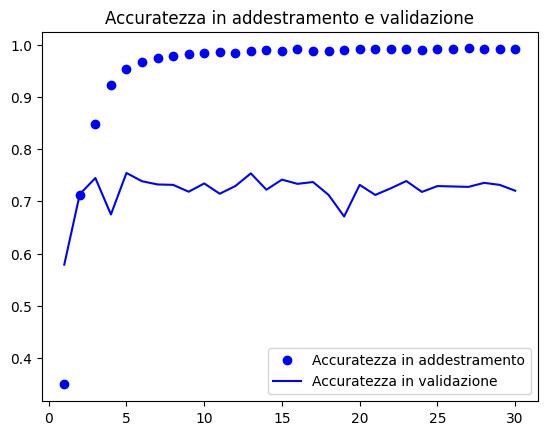

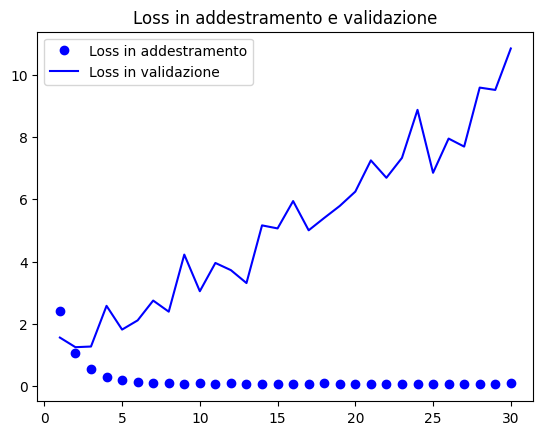

In [15]:
create_train_val_plot(basic_model_history)

Questi grafici mostrano come il nostro modello sia andato immediatamente in overfitting. L'accuratezza dell'addestramento aumenta col tempo e raggiunge quasi il **100%**, mentre l'accuratezza della validazione varia dal **70% al 80%** con un picco del 78%. Inoltre, la **perdita nel set di addestramento** continua a diminuire mentre la **perdita nel set di validazione** aumenta.

Possiamo verificare l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**.

In [16]:
best_basic_model = tf.keras.models.load_model("bestmodels/basic_model.keras")
test_loss, test_acc = best_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 12ms/step - loss: 1.3385 - accuracy: 0.6959
Accuratezza: 0.696


Abbiamo ottenuto un'**accuratezza** del **XX%**! Considerata la complessità del task non è male.

Infine, creiamo una funzione utile a visualizzare graficamente la distribuzione di accuratezza delle classi su un'immagine casuale, per capire come ha lavorato il modello. Nel caso il modello non predice correttamente, la **classe corretta** verrà sempre evidenziata di **verde** mentre la **classe predetta** verrà evidenziata di **giallo**.

In [17]:
def create_distribution_plot(model, audio, label):
    prediction = model(audio)
    softmax_pred = tf.nn.softmax(prediction[0])
    pred_label = np.argmax(softmax_pred)

    colors = ['indianred'] * len(label_names)

    if pred_label == label[0].numpy():
        colors[pred_label] = 'seagreen'
    else:
        colors[pred_label] = 'khaki'
        colors[label[0].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))

    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    if pred_label == label[0].numpy():
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

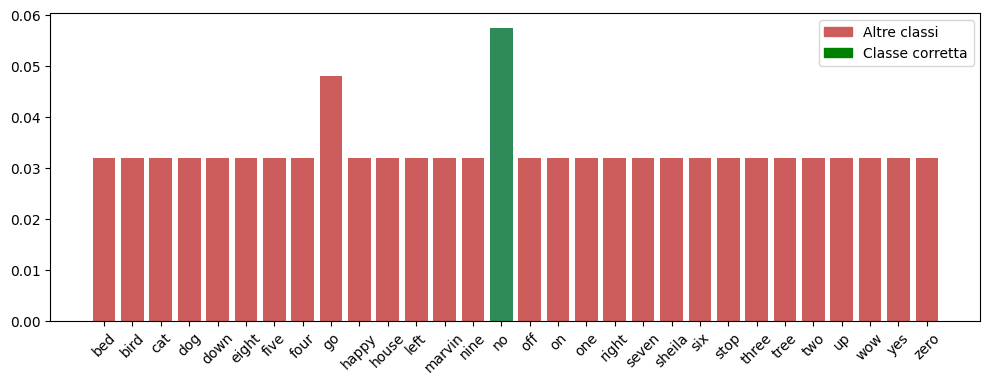

In [18]:
for audio, label in test_ds:
    create_distribution_plot(best_basic_model, audio, label)
    break

L'overfitting è probabilmente fortemente causato dal fatto che il nostro dataset contiene un numero insufficente di campioni, rendendolo non in grado di generalizzare su dati nuovi. Per migliorare questa capacità andremo a utilizzare diverse tecniche quali: data agumentation; blocchi residuali; normalizazzione dei batch; convoluzioni separabili.

## Gestione dell'Overfitting

Per contrastare l'overfitting la prima tecnica che adopereremo è quella della data augmentation. Essa consiste nell'aumentare in modo artificiale il numero di campioni da cui apprendere, cosi facendo si dovrebbe rendere il modello più robusto e capace di generalizzare vannacci.

Per eseguire questa tecnica si ha bisogno di alcuni strati in grado di produrre nuove immagini a partire da quelle presenti nel dataset. Per questo abbiamo utilizzato gli strati già presenti nella libraria tensorflow: `tf.keras.layers.RandomFlip("horizontal")` per specchiare l'immagine rispetto all'asse verticale; `tf.keras.layers.RandomRotation(0.1)` per ruotare in modo casuale l'immagine.

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
    # tf.keras.layers.RandomZoom(0.2) # -> non ci stava dando risultati e raddoppiava il tempo di training (40s in totale per epoca)
    # tf.keras.layers.RandomTranslation(height_factor=5/124, width_factor=0)
    # tf.keras.layers.RandomTranslation(height_factor=0, width_factor=5/129)
    # questi ultimi due layer non ci stavano dando risultati e aumentava di molto il tempo di training (1:30 minuti per epoca)
    # l'idea era quella di traslare le immagini di 5 pixel per la X e 5 pixel per la Y
])

La sola data augmentation potrebbe non bastare a combattere l'overfitting, quindi all'architettura precedente vengono aggiunti oltre che i layer utili alla data augmentation appena creati, anche uno di `dropout`, prima del livello densamente connesso. Quest ultimo disattiva la metà dei nodi, rendendo più difficile il processo di allenamento al modello, dovrebbe quindi risultare più robusto.

In [21]:
def get_improved_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = data_augmentation(inputs)
    x = tf.keras.layers.Resizing(120, 120)(x)
    x = tf.keras.layers.Normalization()(x)

    # Livelli per l'apprendimento della rappresentazione delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [22]:
improved_basic_model = get_improved_basic_model()
improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Alleniamo ed addestriamo questo nuovo modello. Essendo più complesso, ci si aspetta che ci metti più tempo ad andare in overfitting rispetto a quello precedente, quindi lo viene allenato per un numero di **epoche pari a 100**.

In [23]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 8s 24ms/step - loss: 3.2605 - accuracy: 0.0934 - val_loss: 2.8419 - val_accuracy: 0.2157
Epoch 2/100
243/243 [==============================] - 5s 22ms/step - loss: 2.8325 - accuracy: 0.2188 - val_loss: 2.6950 - val_accuracy: 0.2488
Epoch 3/100
243/243 [==============================] - 5s 22ms/step - loss: 2.4654 - accuracy: 0.3184 - val_loss: 2.4129 - val_accuracy: 0.3237
Epoch 4/100
243/243 [==============================] - 5s 22ms/step - loss: 2.1553 - accuracy: 0.4088 - val_loss: 2.1112 - val_accuracy: 0.4086
Epoch 5/100
243/243 [==============================] - 5s 22ms/step - loss: 1.9256 - accuracy: 0.4649 - val_loss: 1.6666 - val_accuracy: 0.5243
Epoch 6/100
243/243 [==============================] - 5s 22ms/step - loss: 1.7494 - accuracy: 0.5112 - val_loss: 1.6112 - val_accuracy: 0.5440
Epoch 7/100
243/243 [==============================] - 5s 22ms/step - loss: 1.6503 - accuracy: 0.5397 - val_loss: 1.5347 - val_accuracy:

Il grafico conferma l'ipotesi appena esposta, l'overfitting si verifica, infatti, dopo molte più epoche rispetto al primo modello, circa **40** contro le **5** di quello orginale.
Inoltre, l'accuratezza sul validation set in generale è aumentata, attestandosi intorno al **77%** e arrivando fino all'**80%**.


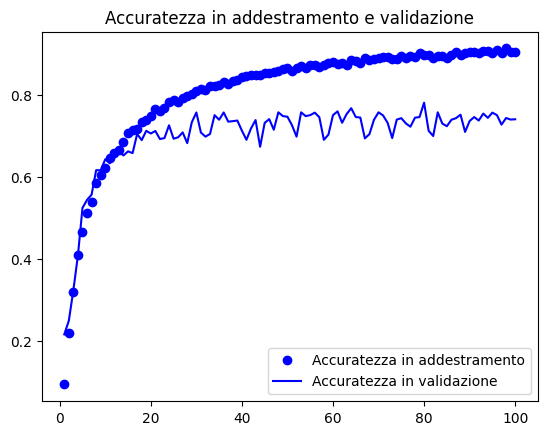

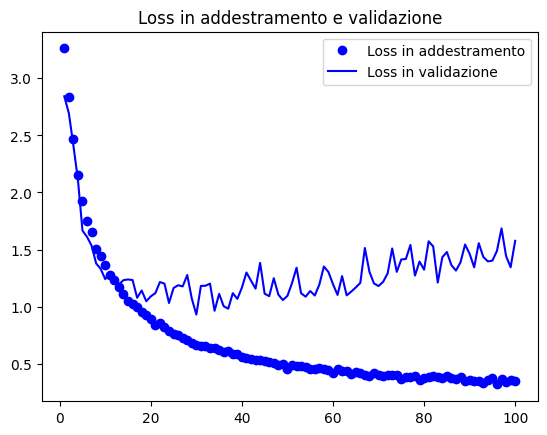

In [24]:
create_train_val_plot(improved_history)

In [25]:
improved_best_model = tf.keras.models.load_model("bestmodels/improved_basic_model.keras")
test_loss, test_acc = improved_best_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 8ms/step - loss: 0.9862 - accuracy: 0.7462
Accuratezza: 0.746


Eseguendo queste semplici modifiche siamo riusciti ad ottenere un valore di accuratezza sul test set del **XX%**, ben **XX** punti percentuale in più rispetto all'originale.
Mostriamo, come nel precedente il grafico della distribuzione di probabilità di un immagine casuale. In questo caso il modello ha correttamente classificato il dato scelto!

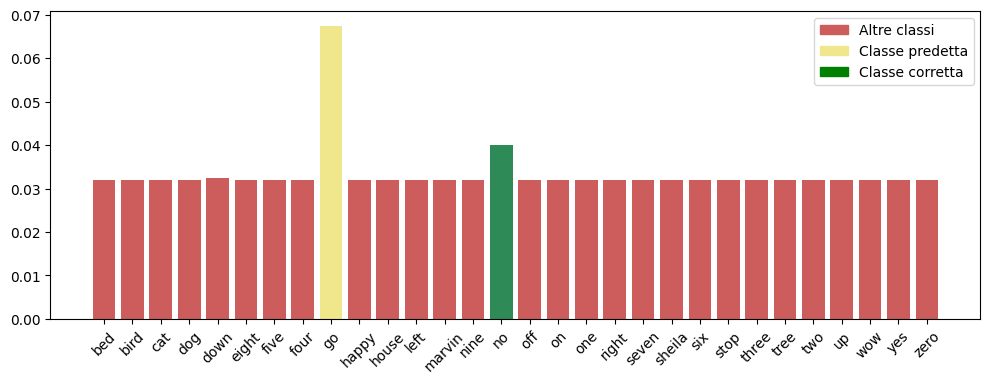

In [26]:
for audio, label in test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

## Miglioramenti all'architettura del modello

Esistono altre best-practice architetturali che possono far raggiungere prestazioni migliori al modello. Nelle seguenti celle esploreremo i blocchi residuali.

La differenza tra la tecnica introdotta nel paragrafo precede e quelle che esamineremo a breve risiede nell'obiettivo. Inizialemente, si mirava ad evitare che il modello si adattasse eccessivamente ai dati a disposizione. Ora, invece, vengono eseguite una serie di attivitò che rendono l'apprendimento dai dati più efficace.

### Blocchi residuali
Nelle architetture particolarmente profonde, si rischia ti propagare rumore nei layer, il che può sopraffare le informazioni sul gradiente, rendendo inefficace la backpropagation. Questo problema è noto come **gradienti evanescenti**. Per risolvere questo problema si può forzare il modello a essere non distruttivo, ovvero capace di conservare una versione priva di rumore delle informazioni contenute nell'input precedente.

La funzione `residual_block` è il fulcro del modello, poiché definisce ogni singolo blocco residuale. Riceve come argomenti i tensori **x** e la **dimensione dell'output** per i livelli convolutivi.
I tensori vengono assegnati alla variabile **residual**, per tenere una coppia da sommare ai tensori a cui sono state applicate le funzioni **distruttive** `tf.keras.layers.SeparableConv2D` e `tf.keras.layers.Conv2D`.
Utilizziamo un livello convoluzionale separabile perché migliora l'efficienza computazionale e riduce il numero di parametri rispetto a una convoluzione standard.

La funzione `bp_basic_model()` definisce l'architettura del modello. Alterna una coppia di blocchi residui a un livello di `MaxPooling`. Dopo l'ultimo blocco residuo, invece di un livello `flatten`, viene utilizzato uno strato `GlobalAveragePooling2D`, in grado di ridurre ogni mappa di attivazione ad un singolo valore medio, riducendo la dimensione a **1**. Si procede quindi con il dropout e il livello softmax.

In [35]:
def residual_block(x, size):
    residual = x
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    residual = tf.keras.layers.Conv2D(size, 1, padding="same", use_bias=False)(residual)
    return tf.keras.layers.add([x, residual])


def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = data_augmentation(inputs)
    x = tf.keras.layers.Resizing(120, 120)(x)
    x = tf.keras.layers.Normalization()(x)

    x = residual_block(x, 16)

    x = residual_block(x, 32)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = residual_block(x, 64)

    x = residual_block(x, 128)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = residual_block(x, 256)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [36]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

bp_basic_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 129, 1)         0         ['input_5[0][0]']             
                                                                                                  
 resizing_4 (Resizing)       (None, 120, 120, 1)          0         ['sequential[3][0]']          
                                                                                                  
 normalization_4 (Normaliza  (None, 120, 120, 1)          3         ['resizing_4[0][0]']          
 tion)                                                                                      

Si può notare il fatto che i parametri sono stati ridotti a circa il 10% rispetto al modello precedente, grazie al **livello convolutivo separabile**.

In [37]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/bp_basic_model.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 11s 35ms/step - loss: 3.3637 - accuracy: 0.0606 - val_loss: 3.4047 - val_accuracy: 0.0401
Epoch 2/100
243/243 [==============================] - 9s 36ms/step - loss: 3.1906 - accuracy: 0.1015 - val_loss: 3.2528 - val_accuracy: 0.0644
Epoch 3/100
243/243 [==============================] - 9s 35ms/step - loss: 3.1050 - accuracy: 0.1215 - val_loss: 3.1106 - val_accuracy: 0.1292
Epoch 4/100
243/243 [==============================] - 8s 35ms/step - loss: 3.0534 - accuracy: 0.1366 - val_loss: 2.9531 - val_accuracy: 0.1393
Epoch 5/100
243/243 [==============================] - 8s 34ms/step - loss: 2.9948 - accuracy: 0.1482 - val_loss: 3.0042 - val_accuracy: 0.1593
Epoch 6/100
243/243 [==============================] - 8s 34ms/step - loss: 2.9302 - accuracy: 0.1733 - val_loss: 3.0757 - val_accuracy: 0.1470
Epoch 7/100
243/243 [==============================] - 8s 34ms/step - loss: 2.8495 - accuracy: 0.1988 - val_loss: 3.5075 - val_accuracy

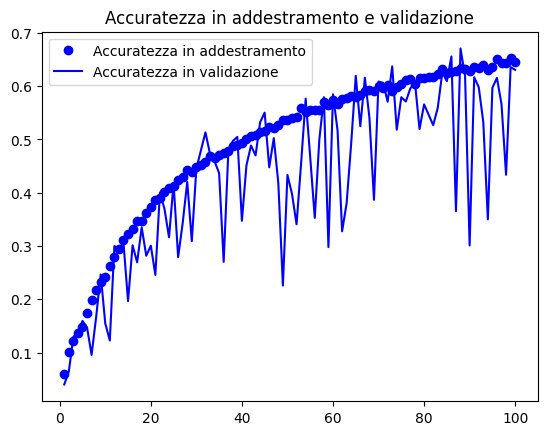

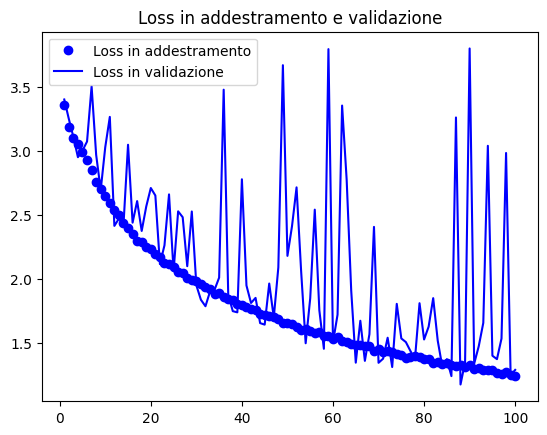

In [38]:
create_train_val_plot(bp_model_history)

Dopo aver allenato il modello per **X** epoche, i grafici fanno capire come l'accuratezza continui a migliore e la perdita diminuisca per entrambi i set, senza presentare il problema di overfitting.

In [39]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/bp_basic_model.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 11ms/step - loss: 1.2211 - accuracy: 0.6606
Accuratezza: 0.661


L'accuratezza sul test set è **XX%**. Lo reputiamo un ottimo risultato dato il numero di parametri.

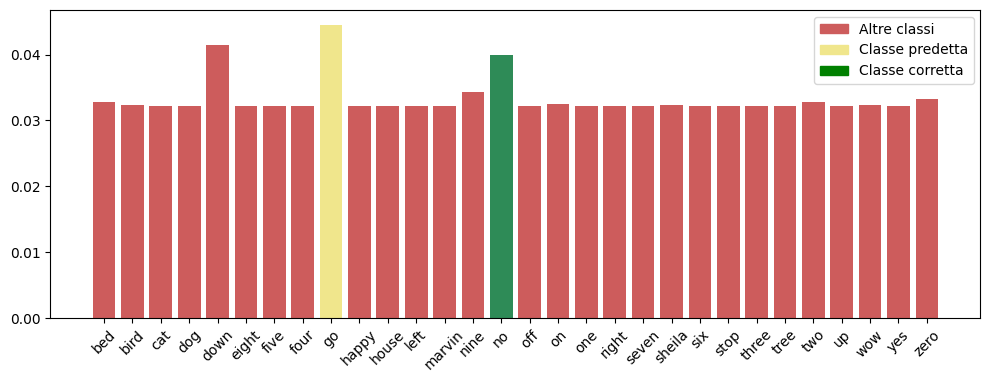

In [40]:
for audio, label in test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break